<a href="https://colab.research.google.com/github/shchepos/DS-project---Road-accidents-in-France/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/DataScience project/accidents_for_classification_model_2.csv', 'r', encoding='ISO-8859-1') as f:
  df = pd.read_csv(f, index_col=0)

df.info()

Mounted at /content/drive


<ipython-input-3-183c83831d3e>:6: DtypeWarning: Columns (8,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, index_col=0)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2312230 entries, 0 to 2312229
Data columns (total 33 columns):
 #   Column   Dtype  
---  ------   -----  
 0   grav     float64
 1   place    float64
 2   catu     int64  
 3   sexe     float64
 4   trajet   float64
 5   secu     float64
 6   locp     float64
 7   actp     object 
 8   etatp    float64
 9   senc     float64
 10  catv     float64
 11  occutc   float64
 12  obs      float64
 13  obsm     float64
 14  choc     float64
 15  manv     float64
 16  catr     int64  
 17  circ     float64
 18  prof     float64
 19  plan     float64
 20  lartpc   float64
 21  larrout  float64
 22  surf     float64
 23  infra    float64
 24  situ     float64
 25  env1     float64
 26  lum      float64
 27  agg      int64  
 28  int      float64
 29  atm      float64
 30  col      float64
 31  dep      object 
 32  age      float64
dtypes: float64(28), int64(3), object(2)
memory usage: 599.8+ MB


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

1.0    0.410367
4.0    0.363716
3.0    0.199277
2.0    0.026613
0.0    0.000026
Name: grav, dtype: float64


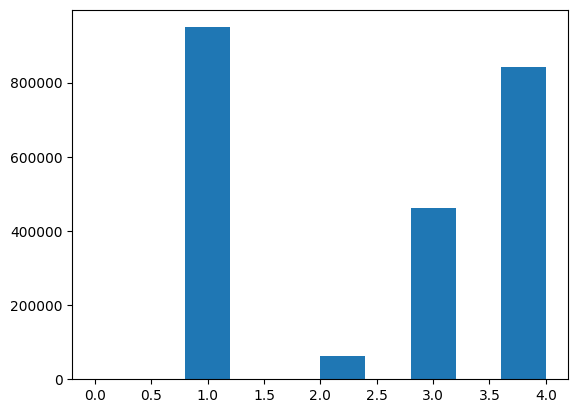

In [6]:
import matplotlib.pyplot as plt

print(df.grav.value_counts(normalize=True))

plt.hist(df.grav);

<ipython-input-7-8c5ca49c4086>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),  annot=True, cmap="RdBu_r", center =0);


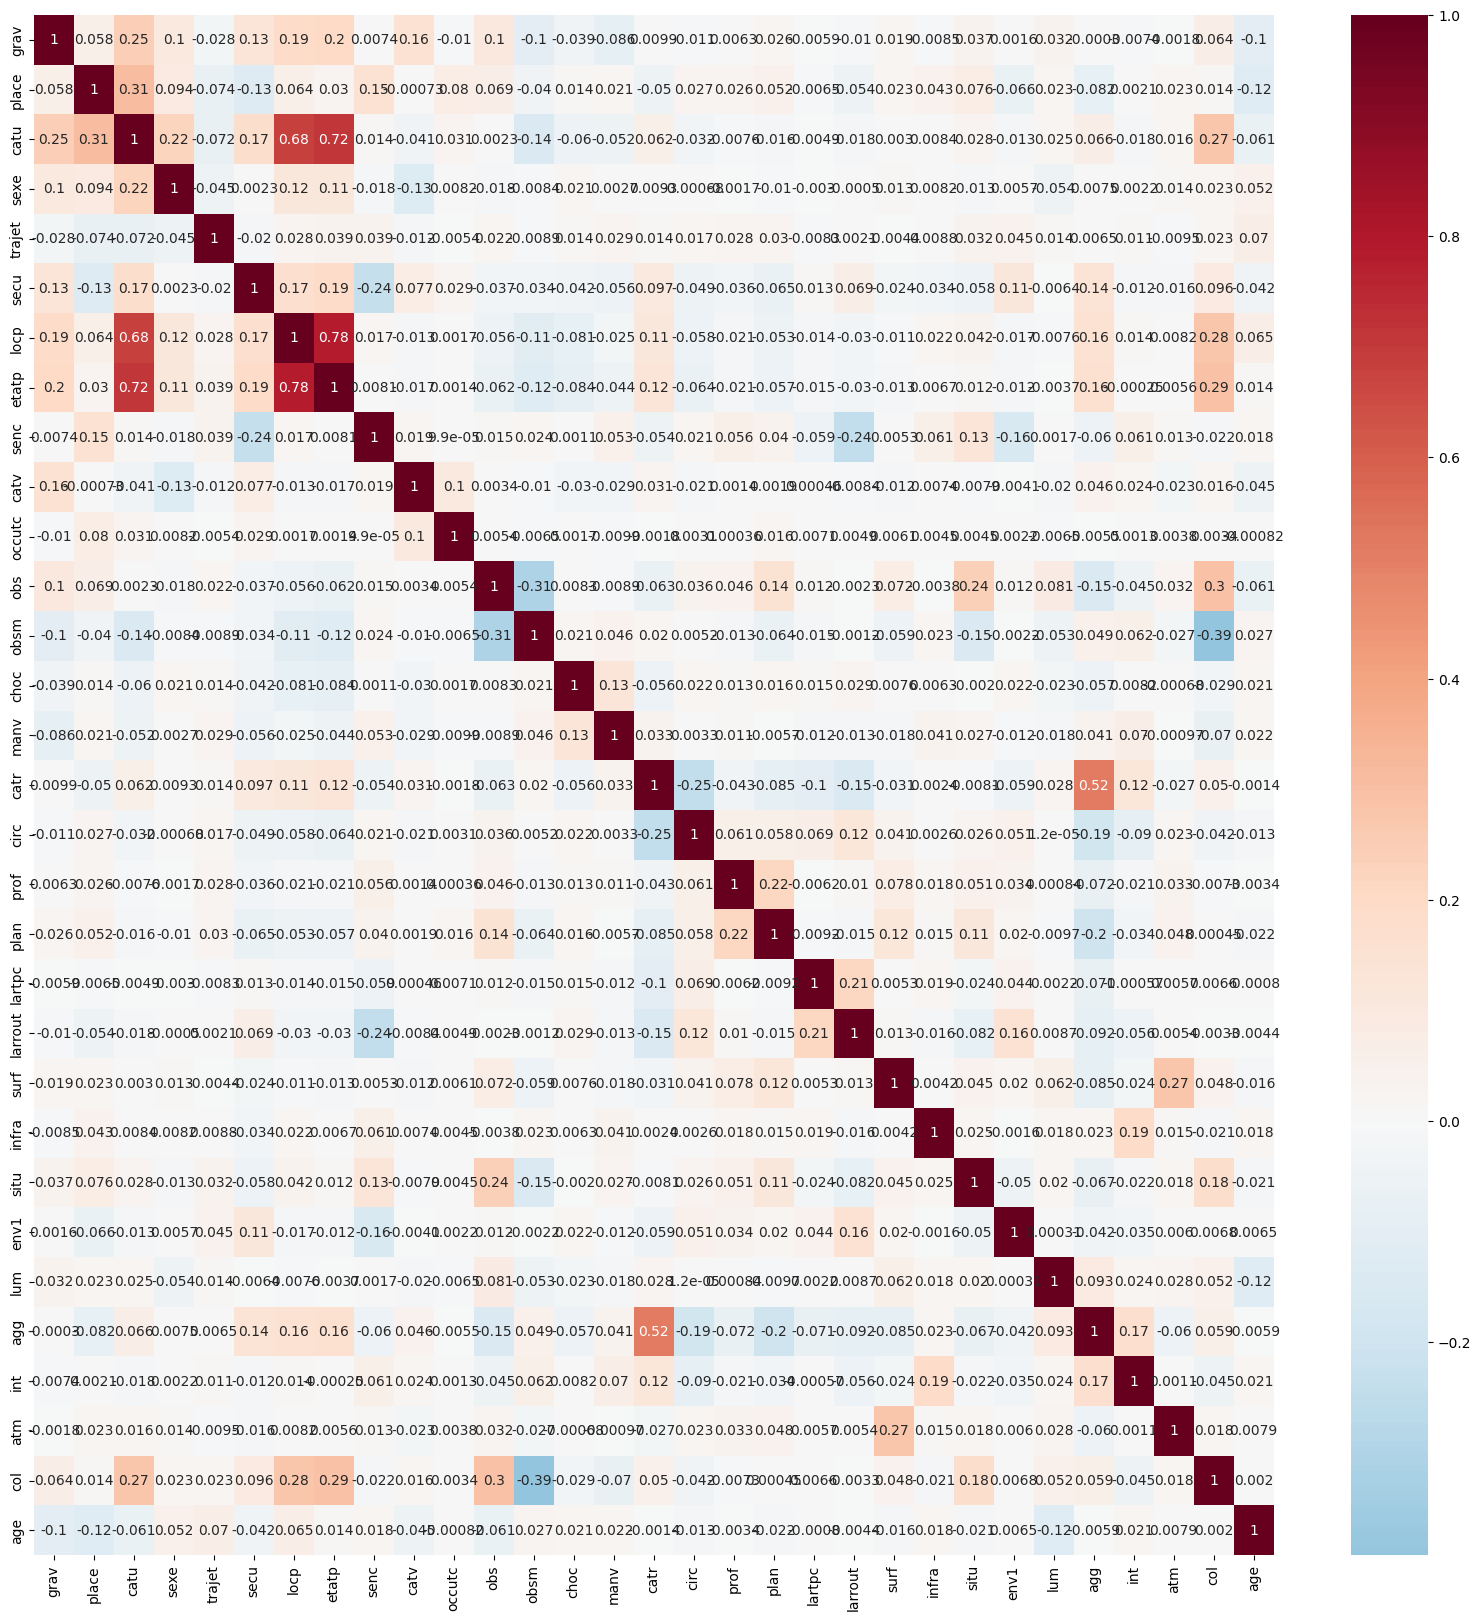

In [7]:
# remove class 0 value 
df = df[df.grav != 0]

import seaborn as sns

plt.figure(figsize=(20,20))
# most of all features are still considered as continuous (while they are categorical indeed)
# so we can plot correlation map 
sns.heatmap(df.corr(),  annot=True, cmap="RdBu_r", center =0);
     

In [8]:
columns = df.columns.drop(['age', 'lartpc', 'larrout', 'occutc', 'grav'])
df[columns] = df[columns].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2312170 entries, 0 to 2312229
Data columns (total 33 columns):
 #   Column   Dtype   
---  ------   -----   
 0   grav     float64 
 1   place    category
 2   catu     category
 3   sexe     category
 4   trajet   category
 5   secu     category
 6   locp     category
 7   actp     category
 8   etatp    category
 9   senc     category
 10  catv     category
 11  occutc   float64 
 12  obs      category
 13  obsm     category
 14  choc     category
 15  manv     category
 16  catr     category
 17  circ     category
 18  prof     category
 19  plan     category
 20  lartpc   float64 
 21  larrout  float64 
 22  surf     category
 23  infra    category
 24  situ     category
 25  env1     category
 26  lum      category
 27  agg      category
 28  int      category
 29  atm      category
 30  col      category
 31  dep      category
 32  age      float64 
dtypes: category(28), float64(5)
memory usage: 169.8 MB


In [9]:
grav_count = df.grav.value_counts(normalize=True)
grav_count = grav_count.reset_index().rename(columns={'grav': 'grav_count', 'index': 'grav'})
print(grav_count)

# dataset is too large for prediction
# try to do sampling by keeping sample proportion on gravity
df = pd.merge(df, grav_count, on='grav')
# is it enough to reduce size by 50%
# Still OOM
# df = df.sample(frac=0.5, weights='grav_count')
# try with 0.3


#working on weak computer - using 5% sample of data
#SVM takes too much time
df = df.sample(frac=0.05, weights='grav')
# class 2 (death) proportion is reduced 10 times after pandas sampling
# need to revise sampling technique
print(df.grav.value_counts(normalize=True))

   grav  grav_count
0   1.0    0.410378
1   4.0    0.363725
2   3.0    0.199282
3   2.0    0.026614
4.0    0.571803
3.0    0.239603
1.0    0.167540
2.0    0.021054
Name: grav, dtype: float64


In [10]:
# separation of features and target variables
target = df.grav.astype('category') # convert to string for classification
feats = df.drop(columns=['grav'])  

In [11]:
# convert categorical variables to numeric using dummy
feats = pd.get_dummies(feats)
feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115608 entries, 770708 to 755040
Columns: 489 entries, occutc to dep_988
dtypes: float64(5), uint8(484)
memory usage: 58.7 MB


In [12]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state=123)

In [13]:
del df
del feats
del target

In [14]:
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np

In [15]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report

ridge_csf = RidgeClassifier()
ridge_csf.fit(X_train, y_train)
print('Score on test', ridge_csf.score(X_test, y_test))

y_pred = ridge_csf.predict(X_test)

print(classification_report(y_test, y_pred))

print(pd.crosstab(y_test, y_pred, rownames=['True grav'], colnames=['Predicted grav']))
     

Score on test 0.8372978116079924
              precision    recall  f1-score   support

         1.0       0.74      0.27      0.39      3949
         2.0       0.00      0.00      0.00       463
         3.0       0.92      1.00      0.96      5552
         4.0       0.81      0.97      0.89     13158

    accuracy                           0.84     23122
   macro avg       0.62      0.56      0.56     23122
weighted avg       0.81      0.84      0.80     23122

Predicted grav   1.0   3.0    4.0
True grav                        
1.0             1055     0   2894
2.0                0   463      0
3.0                0  5526     26
4.0              379     0  12779


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc=rfc.predict(X_test)

display(pd.crosstab(y_test, y_pred_rfc))
rfc.score(X_test, y_test)

print(classification_report(y_test, y_pred_rfc))

print(pd.crosstab(y_test, y_pred_rfc, rownames=['True grav'], colnames=['Predicted grav']))
     

col_0,1.0,2.0,3.0,4.0
grav,,,,
1.0,3726,0,1,222
2.0,0,83,370,10
3.0,0,0,5520,32
4.0,0,0,0,13158


              precision    recall  f1-score   support

         1.0       1.00      0.94      0.97      3949
         2.0       1.00      0.18      0.30       463
         3.0       0.94      0.99      0.96      5552
         4.0       0.98      1.00      0.99     13158

    accuracy                           0.97     23122
   macro avg       0.98      0.78      0.81     23122
weighted avg       0.97      0.97      0.97     23122

Predicted grav   1.0  2.0   3.0    4.0
True grav                             
1.0             3726    0     1    222
2.0                0   83   370     10
3.0                0    0  5520     32
4.0                0    0     0  13158


In [17]:
#SVM 
#from sklearn.svm import SVC
#svc=SVC()
#svc.fit(X_train, y_train)
#y_pred_svc=svc.predict(X_test)
#
#display(pd.crosstab(y_test, y_pred_svc))
#svc.score(X_test, y_test)
#print(classification_report(y_test, y_pred_svc))

#print(pd.crosstab(y_test, y_pred_svc, rownames=['True grav'], colnames=['Predicted grav']))
     


In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92486 entries, 2310962 to 1883907
Columns: 489 entries, occutc to dep_988
dtypes: float64(5), uint8(484)
memory usage: 46.9 MB


In [19]:
# try to use imbalance sampling technique to keep minor class (death)
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import f1_score


X_ru, y_ru = RandomUnderSampler().fit_resample(X_train.values, y_train.ravel())



In [20]:
ridge_csf.fit(X_ru, y_ru)
print('test score', ridge_csf.score(X_test, y_test))

y_pred = ridge_csf.predict(X_test)
print(pd.crosstab(y_test, y_pred))

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RidgeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RidgeClassifier was fitted without feature names
  warnings.warn(


test score 0.6267623907966439
col_0   1.0   2.0   3.0   4.0
grav                         
1.0    3191     0    20   738
2.0       0   453    10     0
3.0      72  2599  2332   549
4.0    4121     0   521  8516


In [21]:
rfc=RandomForestClassifier()
rfc.fit(X_ru, y_ru)
y_pred_rfc=rfc.predict(X_test)


print('test score', rfc.score(X_test, y_test))

print(pd.crosstab(y_test, y_pred_rfc))


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


test score 0.9268661880460167
col_0   1.0  2.0   3.0    4.0
grav                         
1.0    3789    6    72     82
2.0       0  432    25      6
3.0      21   46  5170    315
4.0      98   59   961  12040


In [22]:
#SVM 
#from sklearn.svm import SVC
#svc=SVC()
#svc.fit(X_ru, y_ru)
#y_pred_svc=svc.predict(X_test)
#
#print('test score',svc.score(X_test, y_test))
#print(pd.crosstab(y_test, y_pred_svc))


In [23]:
clf_rg = RidgeClassifier()
clf_rf = RandomForestClassifier()
clf_svc = SVC()

In [24]:
parm_grid_rg = [{'alpha':[0.01, 0.1, 0.5, 1, 10, 50, 100]}]

param_grid_rf = [{'n_estimators': [2, 5, 10, 50], 
                  'min_samples_leaf': [1, 3, 5], 
                  'max_features': ['sqrt']}]
#param_grid_rf = [{'n_estimators': [2, 4, 6, 8, 10, 25, 50], 
#                  'min_samples_leaf': [2, 4, 6, 8, 10, 20], 
                  #'max_features': ['sqrt']}]
#                  'max_features': ['sqrt', 'log2']}]

#param_grid_svc = [{'C': [0.1, 1, 10, 50], 'kernel': ['rbf', 'linear']}] 
param_grid_svc = [{'C': [1], 'kernel': ['linear']}] 

In [25]:
gridcvs = {}
 

for pgrid, clf, name in zip((parm_grid_rg, param_grid_rf, param_grid_svc),
                            (clf_rg, clf_rf, clf_svc),
                            ('RG', 'RF', 'SVC')):
    gcv = GridSearchCV(clf, pgrid, cv=3, refit=True)
    gridcvs[name] = gcv  

In [ ]:
outer_cv = StratifiedKFold(n_splits=3, shuffle=True)
outer_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, X_ru, y_ru, cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')


RG: outer accuracy 70.50 +/- 0.35
RF: outer accuracy 93.36 +/- 0.79


In [ ]:
from sklearn.metrics import accuracy_score

final_clf = gridcvs['RF']
final_clf.fit(X_ru, y_ru)

print(f'Best Parameters: {final_clf.best_params_}')

train_acc = accuracy_score(y_true=y_ru, y_pred=final_clf.predict(X_ru))
test_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')
